In [365]:
# Import
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

import os
import random
from shutil import copyfile

import cv2
import matplotlib.pyplot as plt

In [366]:
# Constants
HEIGHT = 64
WIDTH = 64
BATCH_SIZE = 32
SPLIT_RATIO = 0.8
TARGET_SIZE = (HEIGHT, WIDTH)

In [367]:
# Unzip file
import tarfile

filename = 'dataset/synthetic_sugarbeet_random_weeds'

# my_tar = tarfile.open(filename + '.tar.gz')
# my_tar.extractall('dataset')
# my_tar.close()

In [368]:
# Function to create all directories from a string path
def make_directory(fullpath):
    splitted_data = fullpath.split('/')
    
    new_dir = []
    current_dir = '.'
    
    for folder in splitted_data:           
        current_dir = current_dir + '/' + folder                
        if not os.path.isdir(current_dir + '/'):
            new_dir.append(current_dir)
            os.mkdir(current_dir)
    
    return new_dir

In [369]:
# Write a python function called split_data which takes
# a FOLDER_IMAGES directory containing the images
# a FOLDER_MASKS directory containing the masks
# a TARGET_FOLDER directory where the files will be copied to
# the TARGET_FOLDER directory will contain 2 subfolders train and test with the data splitted
# a SPLIT SIZE to determine the portion
# The files should also be randomized, so that the training set is a random
# X% of the files, and the test set is the remaining files
# SO, for example, if SPLIT SIZE is .9
# Then 90% of the images will be copied to the TARGET_FOLDER/train dir
# and 10% of the images will be copied to the TARGET_FOLDER/test dir
# Also -- All images should be checked, and if they have a zero file length,
# they will not be copied over
def split_data(FOLDER_IMAGES, FOLDER_MASKS, TARGET_FOLDER, SPLIT_SIZE):

    TRAINING_FOLDER_NAME = TARGET_FOLDER + '/train/'
    TESTING_FOLDER_NAME = TARGET_FOLDER + '/test/'
    TRAINING_FOLDER_NAME_IMAGES = TARGET_FOLDER + '/train/images/img/'
    TRAINING_FOLDER_NAME_MASKS = TARGET_FOLDER + '/train/masks/img/'
    TESTING_FOLDER_NAME_IMAGES = TARGET_FOLDER + '/test/images/img/'
    TESTING_FOLDER_NAME_MASKS = TARGET_FOLDER + '/test/masks/img/'

    # Create directories
    make_directory(TRAINING_FOLDER_NAME_IMAGES)
    make_directory(TRAINING_FOLDER_NAME_MASKS)
    make_directory(TESTING_FOLDER_NAME_IMAGES)
    make_directory(TESTING_FOLDER_NAME_MASKS)
    
    # Remove all data in TRAINING and TESTING dir
    for i_file in os.listdir(TRAINING_FOLDER_NAME_IMAGES):
        os.remove(TRAINING_FOLDER_NAME_IMAGES + i_file)
    for i_file in os.listdir(TRAINING_FOLDER_NAME_MASKS):
        os.remove(TRAINING_FOLDER_NAME_MASKS + i_file)
    for i_file in os.listdir(TESTING_FOLDER_NAME_IMAGES):
        os.remove(TESTING_FOLDER_NAME_IMAGES + i_file)
    for i_file in os.listdir(TESTING_FOLDER_NAME_MASKS):
        os.remove(TESTING_FOLDER_NAME_MASKS + i_file)
    
    dataset = []
    
    # Check for z zero file length
    for i_file in os.listdir(FOLDER_IMAGES):
        data = i_file
        if (os.path.getsize(FOLDER_IMAGES + data) > 0):
            dataset.append(i_file)
        else:
            print('Skipped ' + i_file)
            print('Invalid file size! i.e Zero length.')
    
    # Number of files
    nb_files = len(dataset)
    nb_files_training = int(nb_files * SPLIT_SIZE)
    nb_files_testing = nb_files - nb_files_training
    
    # Suffle dataset
    shuffled_dataset = random.sample(dataset, len(dataset))
        
    # Copy files
    for i_num, i_file in enumerate(shuffled_dataset):
        if i_num < nb_files_training:
            new_path_images = TRAINING_FOLDER_NAME_IMAGES + i_file
            new_path_masks = TRAINING_FOLDER_NAME_MASKS + i_file
        else:
            new_path_images = TESTING_FOLDER_NAME_IMAGES + i_file
            new_path_masks = TESTING_FOLDER_NAME_MASKS + i_file
            
        copyfile(FOLDER_IMAGES + i_file, new_path_images)
        copyfile(FOLDER_MASKS + i_file, new_path_masks)
        
    return nb_files_training

In [370]:
# Split data
FOLDER_IMAGES = "dataset/synthetic_sugarbeet_random_weeds/rgb/"
FOLDER_MASKS = "dataset/synthetic_sugarbeet_random_weeds/gt/"
TARGET_FOLDER = "dataset/synthetic_sugarbeet_random_weeds/train_test/"

NB_TRAINED_IMAGES = split_data(FOLDER_IMAGES, FOLDER_MASKS, TARGET_FOLDER, SPLIT_RATIO)
print('Number of trained images:', NB_TRAINED_IMAGES)

Number of trained images: 1001


In [371]:
# Understand how the mask is made
mask_path = "dataset/synthetic_sugarbeet_random_weeds/gt/"
list_masks = os.listdir(mask_path)

masks_layer1 = []
masks_layer2 = []
masks_layer3 = []
for i in range(5):
    current_mask = cv2.imread(mask_path + list_masks[i])
    masks_layer1 = np.concatenate([masks_layer1, current_mask[:,:,0].flatten()])
    masks_layer2 = np.concatenate([masks_layer1, current_mask[:,:,1].flatten()])
    masks_layer3 = np.concatenate([masks_layer1, current_mask[:,:,2].flatten()])
    
print(set(masks_layer1))
print(set(masks_layer2))
print(set(masks_layer3))

{0.0, 1.0, 2.0}
{0.0, 1.0, 2.0}
{0.0, 1.0, 2.0}


In [372]:
# Plot masks
mask_path = "dataset/synthetic_sugarbeet_random_weeds/gt/"
list_masks = os.listdir(mask_path)

for i in range(3):
    current_mask = cv2.imread(mask_path + list_masks[i])
    current_mask = current_mask*100
    layers = np.concatenate((current_mask[:,:,0], current_mask[:,:,1], current_mask[:,:,2]), axis=1)
    
    if i > 0:
        images = np.concatenate((images, layers), axis=0)
    else:
        images = layers            

# Plot image
cv2.imshow('Example', images) 
cv2.waitKey(0)

-1

In [373]:
# Pre-processing of images and masks
def preprocessing_masks(image):
    img = image>0
    img = tf.cast(img, tf.uint8)
    return img

def preprocessing_images(image):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(img, TARGET_SIZE)
    img = img / 255.
    return img

In [413]:
# Post processing of images and masks for visualization
def postprocessing_masks(image, new_size=TARGET_SIZE):
    img = image>0
    img = img * 255
    img = img.astype(np.uint8)
    img = cv2.resize(img, (new_size[1], new_size[0]))
    return img

def postprocessing_images(image, new_size=TARGET_SIZE):
    img = cv2.resize(image, (new_size[1], new_size[0]))
    return img

In [410]:
# Function to plot an image with its mask
def plot_image_with_mask(image, mask):    
    mask_norm = postprocessing_masks(mask, image.shape)
        
    mixed_image = cv2.addWeighted(image, 0.5, mask_norm, 0.5, 0)      
    raw_images = np.concatenate((image, mask_norm), axis=1)
    example = np.concatenate((raw_images, mixed_image), axis=1)
    
    # Plot image
    cv2.imshow('Example', example) 
    cv2.waitKey(0)

In [411]:
list_files = os.listdir(TARGET_FOLDER + 'train/images/img/')
print('Number of images:', len(list_files))
IMG_ID = 1
print('Selected image:', IMG_ID)

example_image = cv2.imread(TARGET_FOLDER + 'train/images/img/' + list_files[IMG_ID])
example_mask = cv2.imread(TARGET_FOLDER + 'train/masks/img/' + list_files[IMG_ID])

plot_image_with_mask(example_image, example_mask)

Number of images: 1001
Selected image: 1
PP uint8


In [377]:
# Data augmentation (for train dataset)
SEED = 1

train_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.,
                                                                horizontal_flip=True,
                                                                rotation_range=20,
                                                                zoom_range=0.2,
                                                                width_shift_range = 0.1,
                                                                height_shift_range = 0.1)
train_image_generator= train_image_datagen.flow_from_directory(TARGET_FOLDER + 'train/images',
                                                               batch_size=BATCH_SIZE,
                                                               target_size=TARGET_SIZE,
                                                               class_mode=None,
                                                               seed=SEED)

train_mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                                                                horizontal_flip=True,
                                                                rotation_range=20,
                                                                zoom_range=0.2,
                                                                width_shift_range = 0.1,
                                                                height_shift_range = 0.1,
                                                                preprocessing_function=preprocessing_masks)
train_mask_generator= train_image_datagen.flow_from_directory(TARGET_FOLDER + 'train/masks/',
                                                               batch_size=BATCH_SIZE,
                                                               target_size=TARGET_SIZE,
                                                               class_mode=None,
                                                               seed=SEED)

Found 1001 images belonging to 1 classes.
Found 1001 images belonging to 1 classes.


In [378]:
# Data augmentation (for validation dataset)
SEED = 1

val_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)
val_image_generator= val_image_datagen.flow_from_directory(TARGET_FOLDER + 'test/images',
                                                               batch_size=BATCH_SIZE,
                                                               target_size=TARGET_SIZE,
                                                               class_mode=None,
                                                               seed=SEED)

val_mask_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocessing_masks)
val_mask_generator= val_image_datagen.flow_from_directory(TARGET_FOLDER + 'test/masks/',
                                                               batch_size=BATCH_SIZE,
                                                               target_size=TARGET_SIZE,
                                                               class_mode=None,
                                                               seed=SEED)

Found 251 images belonging to 1 classes.
Found 251 images belonging to 1 classes.


In [379]:
# Create generator
def my_image_mask_generator(image_data_generator, mask_data_generator):
    new_generator = zip(image_data_generator, mask_data_generator)
    for (img, mask) in new_generator:
        yield (img, mask)

In [380]:
# parameter describing where the channel dimension is found in our dataset
IMAGE_ORDERING = 'channels_last'

def conv_block(input, filters, strides, pooling_size, pool_strides):
  '''
  Args:
    input (tensor) -- batch of images or features
    filters (int) -- number of filters of the Conv2D layers
    strides (int) -- strides setting of the Conv2D layers
    pooling_size (int) -- pooling size of the MaxPooling2D layers
    pool_strides (int) -- strides setting of the MaxPooling2D layers
  
  Returns:
    (tensor) max pooled and batch-normalized features of the input 
  '''
  # use the functional syntax to stack the layers as shown in the diagram above
  x = tf.keras.layers.Conv2D(filters, strides, padding='same', data_format=IMAGE_ORDERING)(input)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.Conv2D(filters, strides, padding='same')(x)
  x = tf.keras.layers.LeakyReLU()(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=pooling_size, strides=pool_strides)(x)
  x = tf.keras.layers.BatchNormalization()(x)

  return x

In [381]:
# TEST CODE:

test_input = tf.keras.layers.Input(shape=(HEIGHT, WIDTH, 3))
test_output = conv_block(test_input, 32, 3, 2, 2)
test_model = tf.keras.Model(inputs=test_input, outputs=test_output)

print(test_model.summary())

# free up test resources
del test_input, test_output, test_model

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_64 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 32, 32, 32)        128 

In [382]:
def FCN8(input_height=HEIGHT, input_width=WIDTH):
    '''
    Defines the downsampling path of the image segmentation model.

    Args:
      input_height (int) -- height of the images
      width (int) -- width of the images

    Returns:
    (tuple of tensors, tensor)
      tuple of tensors -- features extracted at blocks 3 to 5
      tensor -- copy of the input
    '''
   
    img_input = tf.keras.layers.Input(shape=(input_height,input_width, 3))
    
    # pad the input image to have dimensions to the nearest power of two
    x = tf.keras.layers.ZeroPadding2D(padding=(0, 0))(img_input)

    # Block 1
    x = conv_block(x, filters=32, strides=(3, 3), pooling_size=(2, 2), pool_strides=(2, 2))
    
    # Block 2
    x = conv_block(x, filters=64, strides=(3, 3), pooling_size=(2, 2), pool_strides=(2, 2))

    # Block 3
    x = conv_block(x, filters=128, strides=(3, 3), pooling_size=(2, 2), pool_strides=(2, 2))
    # save the feature map at this stage
    f3 = x

    # Block 4
    x = conv_block(x, filters=256, strides=(3, 3), pooling_size=(2, 2), pool_strides=(2, 2))
    # save the feature map at this stage
    f4 = x

    # Block 5
    x = conv_block(x, filters=256, strides=(3, 3), pooling_size=(2, 2), pool_strides=(2, 2))
    # save the feature map at this stage
    f5 = x
  
    return (f3, f4, f5), img_input

In [383]:
# TEST CODE:
test_convs, test_img_input = FCN8()
test_model = tf.keras.Model(inputs=test_img_input, outputs=[test_convs, test_img_input])

print(test_model.summary())

del test_convs, test_img_input, test_model

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
zero_padding2d_6 (ZeroPaddin (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_66 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
leaky_re_lu_67 (LeakyReLU)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 32, 32, 32)        0   

In [384]:
def fcn8_decoder(convs, n_classes):
  # features from the encoder stage
  f3, f4, f5 = convs

  # number of filters
  n = 512

  # add convolutional layers on top of the CNN extractor.
  o = tf.keras.layers.Conv2D(n , (7 , 7) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING)(f5)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n , (1 , 1) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING)(o)
  o = tf.keras.layers.Dropout(0.5)(o)

  o = tf.keras.layers.Conv2D(n_classes,  (1, 1), activation='relu' , padding='same', data_format=IMAGE_ORDERING)(o)


  # Upsample `o` above and crop any extra pixels introduced
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(f5)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = tf.keras.layers.Conv2D(n_classes, kernel_size=(1, 1), activation='relu', padding='same', data_format=IMAGE_ORDERING)(o2)

  # add the results of the upsampling and pool 4 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample the resulting tensor of the operation you just did
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(o)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)

  # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING)(o2)

  # add the results of the upsampling and pool 3 prediction
  o = tf.keras.layers.Add()([o, o2])

  # upsample up to the size of the original image
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)
  o = tf.keras.layers.Cropping2D(((0, HEIGHT-HEIGHT), (0, 0)))(o)

  # append a sigmoid activation
  o = (tf.keras.layers.Activation('sigmoid'))(o)

  return o

In [385]:
# TEST CODE:
test_convs, test_img_input = FCN8()
test_fcn8_decoder = fcn8_decoder(test_convs, 1)

print(test_fcn8_decoder.shape)

del test_convs, test_img_input, test_fcn8_decoder

(None, 64, 64, 1)


In [386]:
# start the encoder using the default input size 64 x 84
convs, img_input = FCN8()

# pass the convolutions obtained in the encoder to the decoder
n_classes = 3
dec_op = fcn8_decoder(convs, n_classes)

print(dec_op.shape)

# define the model specifying the input (batch of images) and output (decoder output)
model = tf.keras.Model(inputs = img_input, outputs = dec_op)

(None, 64, 64, 3)


In [ ]:
# Create custom generator for training images and masks
# my_train_generator = my_image_mask_generator(train_image_generator, train_mask_generator)
# my_val_generator = my_image_mask_generator(val_image_generator, val_mask_generator)

my_train_generator = zip(train_image_generator, train_mask_generator)
my_val_generator = zip(val_image_generator, val_mask_generator)

# Compile your model here
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

steps = NB_TRAINED_IMAGES / BATCH_SIZE

# Train your model here
history = model.fit(my_train_generator,
                    steps_per_epoch=steps,
                    epochs=30,
                    verbose=1,
                    validation_data=my_val_generator,
                    validation_steps=steps)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 31.28125 steps, validate for 31.28125 steps
Epoch 1/30
32/31 [==============================] - 31s 978ms/step - loss: 0.0015 - accuracy: 0.9452 - val_loss: 0.0016 - val_accuracy: 0.9606
Epoch 2/30
32/31 [==============================] - 29s 904ms/step - loss: 0.0015 - accuracy: 0.9486 - val_loss: 0.0016 - val_accuracy: 0.9610
Epoch 3/30
32/31 [==============================] - 28s 890ms/step - loss: 0.0015 - accuracy: 0.9458 - val_loss: 0.0016 - val_accuracy: 0.9601
Epoch 4/30
32/31 [==============================] - 34s 1s/step - loss: 0.0015 - accuracy: 0.9476 - val_loss: 0.0016 - val_accuracy: 0.9606
Epoch 5/30
32/31 [==============================] - 33s 1s/step - loss: 0.0015 - accuracy: 0.9472 - val_loss: 0.0015 - val_accuracy: 0.9608
Epoch 6/30
32/31 [==============================] - 32s 1s/step - loss: 0.0016 - accuracy: 0.9451 - val_loss: 0.0016 - val_accuracy: 0.9608
Epoch 7/30
32/31 [=============================

In [415]:
# Plot prediction
IMG_ID = 1
pathname = 'train/images/img/'
list_files = os.listdir(TARGET_FOLDER + pathname)

example_image = cv2.imread(TARGET_FOLDER + 'train/images/img/' + list_files[IMG_ID])
example_mask = cv2.imread(TARGET_FOLDER + 'train/masks/img/' + list_files[IMG_ID])

image_processed = preprocessing_images(example_image)
image_processed = tf.expand_dims(image_processed, axis=0)

prediction = model.predict(image_processed)
pred_image = np.array(tf.squeeze(prediction, axis=0))

image_example_gt = np.concatenate((postprocessing_images(example_image),
                                   postprocessing_masks(example_mask),
                                   pred_image), axis=1)
cv2.imshow('Example', image_example_gt) 
cv2.waitKey(0)

-1

5.067642


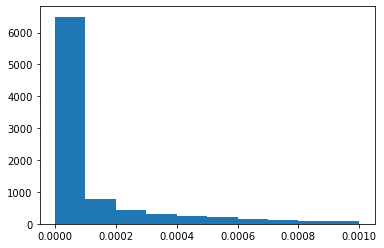

In [426]:
flatten_image = pred_image.flatten()
print(max(flatten_image))